### LSTM Network

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import numpy as np
import re

/Users/madinamukhambekova/opt/anaconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/madinamukhambekova/opt/anaconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/madinamukhambekova/opt/anaconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/

## Data
### Import a binary prediction dataset
* First pick two categories from the list

In [2]:
categories = ['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
binary_categories = ['sci.space','talk.politics.guns']

In [4]:
data = fetch_20newsgroups(categories=binary_categories, remove=['headers', 'footers'])
X = data['data']
y = data['target']

In [5]:
y[0] #label of 1 = guns, 0=space

1

---

## Text preprocessing 

* split 
* drop special characters and stop words

In [6]:
def clean_text(text,label,cap):
    clean_text = []
    clean_label = []
    for i, email in enumerate(text):
        email = email.lower()
        email = re.findall('(?u)\\b\\w\\w+\\b', email)
        if len(email) <= cap:
            clean_text.append(email)
            clean_label.append(label[i])
    return clean_text, clean_label

#### First we'll drop long emails so we don't create too much noise

In [7]:
### This function plots a distribution of the length of each sentence

(array([1.08e+03, 4.00e+01, 1.10e+01, 2.00e+00, 4.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00]),
 array([4.0000e+00, 8.4240e+02, 1.6808e+03, 2.5192e+03, 3.3576e+03,
        4.1960e+03, 5.0344e+03, 5.8728e+03, 6.7112e+03, 7.5496e+03,
        8.3880e+03]),
 <BarContainer object of 10 artists>)

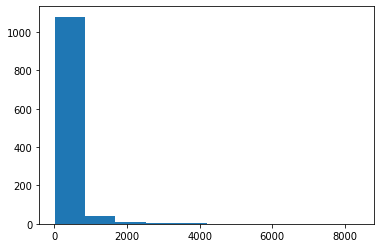

In [8]:
plt.hist([len(x.split()) for x in X])

#### Now do the cleaning

In [9]:
clean_X, clean_y = clean_text(X,y,800)

In [10]:
len(X)

1139

In [11]:
len(clean_X)

1080

---

## Tokenize
#### Make a vocablist for reference

In [12]:
vocab_list = []
for email in clean_X:
    for word in email:
        vocab_list.append(word)
        
vocab_list = list(set(vocab_list))
vocab_size = len(vocab_list) + 1

#### Make a dictionary for words to numbers - an index but not like full text search!

In [13]:
word_to_num = {}

for i, word in enumerate(vocab_list):
    word_to_num[word] = i+1 #i+1 because we're reserving 0 for blank space

In [14]:
word_to_num.items()

dict_items([('plessy', 1), ('stating', 2), ('misdemeanors', 3), ('disadvantages', 4), ('operative', 5), ('lehrer', 6), ('stipulates', 7), ('pool', 8), ('rotc', 9), ('299792', 10), ('invasion', 11), ('probability', 12), ('200', 13), ('preferibly', 14), ('unlikly', 15), ('consumer', 16), ('agendas', 17), ('gfk39017', 18), ('saint', 19), ('endowed', 20), ('cruising', 21), ('pizza', 22), ('fontenot', 23), ('packing', 24), ('rm', 25), ('estimated', 26), ('wired', 27), ('excerpt', 28), ('cost', 29), ('threatened', 30), ('avweek', 31), ('developmental', 32), ('jdg', 33), ('worlds', 34), ('bbs', 35), ('encouraged', 36), ('416', 37), ('syndrome', 38), ('stuff', 39), ('methods', 40), ('tennis', 41), ('credit', 42), ('oc', 43), ('borg', 44), ('toxic', 45), ('c532v3', 46), ('7013', 47), ('visual', 48), ('404', 49), ('barry', 50), ('tt', 51), ('snort', 52), ('criminals', 53), ('25billion', 54), ('peak', 55), ('h0o', 56), ('northcliffe', 57), ('forensic', 58), ('revenge', 59), ('abomination', 60), (

In [15]:
vec_X = [[word_to_num[word] for word in email] for email in clean_X]

In [16]:
word_to_num['in']

1250

In [17]:
clean_X[0][0], vec_X[0][0]

('in', 1250)

#### find the max length of the text, then pad all seqeunces to match that length - input shape in NN has to be consistent!!

In [18]:
max_len = 0
position = 0
for i, email in enumerate(clean_X):
    if len(email) > max_len:
        max_len = len(email)
        position = i
max_len, position

(790, 48)

#### Pad all inputs so they have the same length

In [19]:
pad_vec_X = sequence.pad_sequences(vec_X, maxlen=max_len,padding='pre')

In [20]:
pad_vec_X[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

---

#### This is what we've done in RNNs so far
* download test emails
* removed special characters
* transformed the words into numbers
* cast them into a list
* padded them with zeroes so every email number list has the same length

#### This is what we have to do now
* initialise an lstm
* train in on the Xtrain data 
* test it on our Xtest data

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
Xtrain, Xtest, ytrain, ytest = train_test_split(pad_vec_X, np.array(clean_y))

---

## Now lets create the model
#### We build a sequential model

In [23]:
model = Sequential()

#### Then add a trainable Embedding layer

This layer takes 3 parameters - the size of the vocab (input_dims), the no. of dimensions of each word embedding (output_dim), and the length of each document (input_length), which we've standardised above. It returns a 2d matrix, with rows equal to each word in the document, and columns equal to the number of dimensions in the word embedding. 

*Actually its 3D, cos the batch_size is the first dimension in both input and output, but I find that confuses things more than it clarifies*
Put another way 

The embedding **takes in** a factorized corpus, e.g.:

**[The, cat, sat, on, the, mat]**    becomes    **[1,2,3,4,1,5]**

And **outputs** a word embedded corpus:

**[1,2,3,4,1,5]**    becomes (lets assume output_dim=2)   **[[0.2,0.7], [0.6,0.3], [0.1,0.8], [0.2,0.1], [0.4,0.9], [0.2,0.7]]**

In [24]:
#you could feed in tfidf vectors instead!
model.add(Embedding(input_dim=vocab_size, output_dim=32,input_length=max_len)) #this way creates embeddings during training
#you can also load in pretrained embeddings into the embedding layer - harder to create, but better results

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


#### Now we can add the LSTM layer
* Specify units (the size of the context vector)

In [25]:
model.add(LSTM(128))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [26]:
model.add(Dropout(0.5))

NameError: name 'Dropout' is not defined

Now a Dense prediction layer

In [ ]:
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

---

#### Now we can compile and fit the model

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(Xtrain,ytrain,epochs=20, batch_size=64, validation_split=0.2)

---

#### And check our results

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

In [ ]:
'This class started great and fun and awesome, but then got boring' #negative sentiment

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])

In [ ]:
model.evaluate(Xtest,ytest)

---

#### And test the model on a completely new string

In [ ]:
def test_model(string, model):
    clean_X, clean_y = clean_text([string], [0], 800)
    vec_X = [[word_to_num[word] for word in email if word in vocab_list] for email in clean_X]
    pad_vec_X = sequence.pad_sequences(vec_X, maxlen=max_len,padding='pre')
    return 'space' if model.predict(pad_vec_X)[0] <= 0.5 else 'guns' 

In [ ]:
test_model('this is an email about space', model)

In [ ]:
test_model('this is an email about guns', model)

In [ ]:
test_model('guns guns guns', model)

---

#### Conclusion
* LSTM are v good on sequential data BUT
* Overfit easily - how can treat for that?
* And they still suffer from - word sense disambiguation, long long term memory isn't captured

---

### Next steps
* Birdirectional LSTMs 
* Attention layers
* Pretrained Embeddings

#### BDLSTMs

* [bidirectional layers from tf.keras](https://keras.io/api/layers/recurrent_layers/bidirectional/)

#### Attention
* [tf.keras implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention)
* [customised implementation](https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2)
* [another customised implementation](https://gist.github.com/iridiumblue/622a9525189d48e9c00659fea269bfa4)

#### Pretrained embeddings

[Keras documentation](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)